<a href="https://colab.research.google.com/github/Roshan0505/CVD_HEALTH_PREDICTION/blob/main/CVD_Health_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏥 General Health Prediction from CVD Dataset
### Elewayte ML Internship Project

**Models Used:** SVM · Random Forest · Logistic Regression  
**Target Variable:** `General_Health` (Poor / Fair / Good / Very Good / Excellent)  
**Pipeline:** Load → Preprocess → Train (80%) → Test (20%) → Evaluate → Hyperparameter Tuning → Single Input Prediction

## Step 1 – Install & Import Libraries

In [ ]:
# ── Standard imports ──────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ── Sklearn preprocessing ─────────────────────────────────────────────────────
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ── Models ────────────────────────────────────────────────────────────────────
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# ── Evaluation ────────────────────────────────────────────────────────────────
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

print('✅ All libraries imported successfully!')

## Step 2 – Load the Dataset

In [2]:

from google.colab import files
uploaded = files.upload()

import io
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

# df = pd.read_csv('CVD_cleaned.csv')

print(f'Dataset shape: {df.shape}')
df.head()

Saving CVD_cleaned.csv to CVD_cleaned.csv
Dataset shape: (308854, 19)


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150,32.66,14.54,Yes,0,30,16,12
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165,77.11,28.29,No,0,30,0,4
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163,88.45,33.47,No,4,12,3,16
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180,93.44,28.73,No,0,30,30,8
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191,88.45,24.37,Yes,0,8,4,0


## Step 3 – Exploratory Data Analysis (EDA)

In [3]:

print('Shape:', df.shape)
print('\nColumn names:', df.columns.tolist())
print('\nData types:\n', df.dtypes)
print('\nMissing values:\n', df.isnull().sum())

Shape: (308854, 19)

Column names: ['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

Data types:
 General_Health                   object
Checkup                          object
Exercise                         object
Heart_Disease                    object
Skin_Cancer                      object
Other_Cancer                     object
Depression                       object
Diabetes                         object
Arthritis                        object
Sex                              object
Age_Category                     object
Height_(cm)                       int64
Weight_(kg)                     float64
BMI                             float64
Smoking_History                  object
Alcohol_Consumption               int64


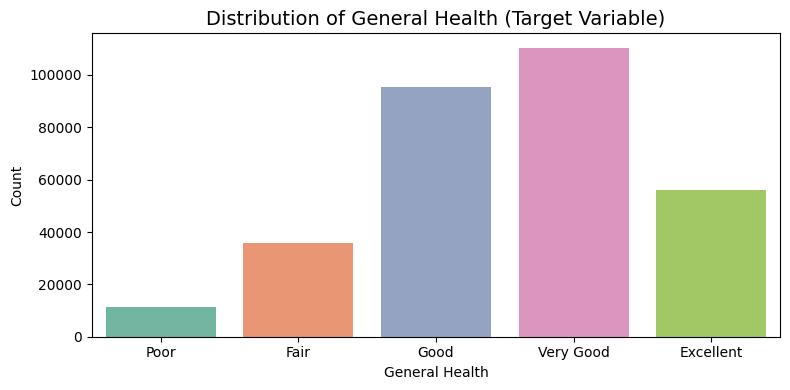

In [4]:
# Distribution of target variable
plt.figure(figsize=(8, 4))
order = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
sns.countplot(data=df, x='General_Health', order=order, palette='Set2')
plt.title('Distribution of General Health (Target Variable)', fontsize=14)
plt.xlabel('General Health')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [5]:
# Statistical summary of numerical columns
df.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000
mean,170.615249,83.588655,28.626211,5.096366,29.835200,15.110441,6.296616
std,10.658026,21.343210,6.522323,8.199763,24.875735,14.926238,8.582954
min,91.000000,24.950000,12.020000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.000000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.000000,12.000000,4.000000
75%,178.000000,95.250000,31.850000,6.000000,30.000000,20.000000,8.000000
max,241.000000,293.020000,99.330000,30.000000,120.000000,128.000000,128.000000


## Step 4 – Data Preprocessing

The dataset has **categorical columns** (like Yes/No, Male/Female, Age ranges).  
We convert all of them into **numbers** using Label Encoding.

In [6]:

df_encoded = df.copy()

# Identify all categorical (object) columns
cat_cols = df_encoded.select_dtypes(include='object').columns.tolist()
print('Categorical columns to encode:', cat_cols)

# Apply Label Encoding to each categorical column
le_dict = {}   # Store encoders so we can use them later for single prediction
for col in cat_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    le_dict[col] = le

print('\n✅ Encoding complete!')
df_encoded.head()

Categorical columns to encode: ['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Smoking_History']

✅ Encoding complete!


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,3,2,0,0,0,0,0,0,1,0,10,150,32.66,14.54,1,0,30,16,12
1,4,4,0,1,0,0,0,2,0,0,10,165,77.11,28.29,0,0,30,0,4
2,4,4,1,0,0,0,0,2,0,0,8,163,88.45,33.47,0,4,12,3,16
3,3,4,1,1,0,0,0,2,0,1,11,180,93.44,28.73,0,0,30,30,8
4,2,4,0,0,0,0,0,0,0,1,12,191,88.45,24.37,1,0,8,4,0


## Step 5 – Define Features (X) and Target (y)

In [7]:
# Target column: General_Health
TARGET = 'General_Health'

X = df_encoded.drop(columns=[TARGET])   # All columns except target
y = df_encoded[TARGET]                  # Only the target

print('Features shape:', X.shape)
print('Target shape  :', y.shape)
print('Target classes:', le_dict[TARGET].classes_)

Features shape: (308854, 18)
Target shape  : (308854,)
Target classes: ['Excellent' 'Fair' 'Good' 'Poor' 'Very Good']


## Step 6 – Train / Test Split (80 : 20)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% for testing
    random_state=42,      # Reproducibility
    stratify=y            # Keep class balance in both sets
)

print(f'Training samples : {X_train.shape[0]}')
print(f'Testing  samples : {X_test.shape[0]}')

Training samples : 247083
Testing  samples : 61771


## Step 7 – Feature Scaling

SVM and Logistic Regression are **sensitive to scale**

We use `StandardScaler` to normalize features.

In [9]:
scaler = StandardScaler()

# Fit ONLY on training data, then transform both
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

print('✅ Scaling done!')

✅ Scaling done!


## Step 8 – Build & Evaluate All Three Models

We train each model on `X_train`, predict on `X_test`, and check:
- **Accuracy Score** – % of correct predictions
- **Classification Report** – Precision, Recall, F1 per class
- **Confusion Matrix** – Visual of correct vs wrong predictions

### 8.1 – Logistic Regression

Logistic Regression Accuracy: 0.4227 (42.27%)

Classification Report:
              precision    recall  f1-score   support

   Excellent       0.45      0.13      0.21     11191
        Fair       0.36      0.12      0.19      7162
        Good       0.41      0.43      0.42     19073
        Poor       0.41      0.05      0.09      2266
   Very Good       0.43      0.70      0.53     22079

    accuracy                           0.42     61771
   macro avg       0.41      0.29      0.29     61771
weighted avg       0.42      0.42      0.38     61771



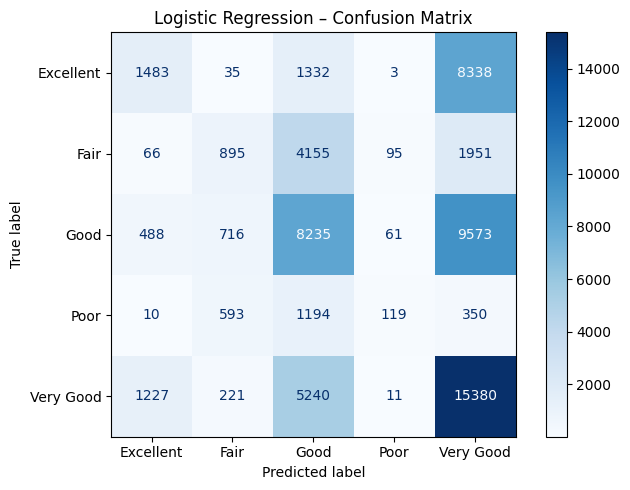

In [10]:
# ── Train ──────────────────────────────────────────────────────────────────────
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_sc, y_train)

# ── Predict ────────────────────────────────────────────────────────────────────
lr_pred = lr_model.predict(X_test_sc)

# ── Evaluate ───────────────────────────────────────────────────────────────────
lr_acc = accuracy_score(y_test, lr_pred)
print(f'Logistic Regression Accuracy: {lr_acc:.4f} ({lr_acc*100:.2f}%)')
print('\nClassification Report:')
print(classification_report(y_test, lr_pred, target_names=le_dict[TARGET].classes_))

# ── Confusion Matrix ───────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test, lr_pred,
    display_labels=le_dict[TARGET].classes_,
    cmap='Blues', ax=ax
)
ax.set_title('Logistic Regression – Confusion Matrix')
plt.tight_layout()
plt.show()

### 8.2 – Random Forest

Random Forest Accuracy: 0.4066 (40.66%)

Classification Report:
              precision    recall  f1-score   support

   Excellent       0.39      0.25      0.30     11191
        Fair       0.33      0.18      0.23      7162
        Good       0.39      0.46      0.42     19073
        Poor       0.34      0.09      0.14      2266
   Very Good       0.43      0.55      0.48     22079

    accuracy                           0.41     61771
   macro avg       0.38      0.30      0.32     61771
weighted avg       0.40      0.41      0.39     61771



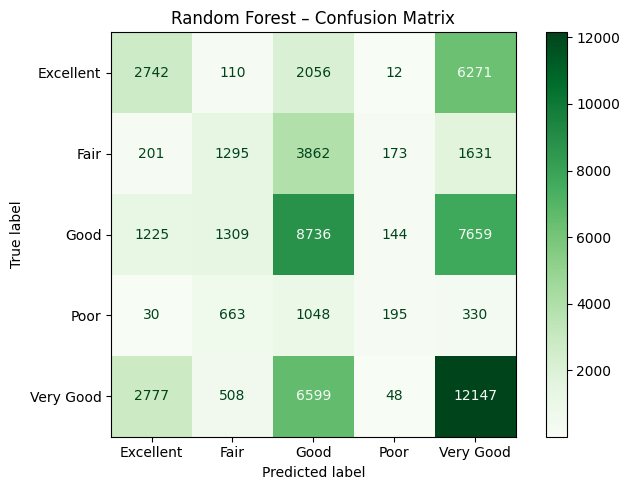

In [11]:
# ── Train ──────────────────────────────────────────────────────────────────────
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)   # RF doesn't need scaled data

# ── Predict ────────────────────────────────────────────────────────────────────
rf_pred = rf_model.predict(X_test)

# ── Evaluate ───────────────────────────────────────────────────────────────────
rf_acc = accuracy_score(y_test, rf_pred)
print(f'Random Forest Accuracy: {rf_acc:.4f} ({rf_acc*100:.2f}%)')
print('\nClassification Report:')
print(classification_report(y_test, rf_pred, target_names=le_dict[TARGET].classes_))

# ── Confusion Matrix ───────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test, rf_pred,
    display_labels=le_dict[TARGET].classes_,
    cmap='Greens', ax=ax
)
ax.set_title('Random Forest – Confusion Matrix')
plt.tight_layout()
plt.show()

### 8.3 – Support Vector Machine (SVM)

 SVM is slow on large datasets. We train on a **sample of 30,000 rows** to keep it manageable.


SVM Accuracy: 0.4211 (42.11%)

Classification Report:
              precision    recall  f1-score   support

   Excellent       0.51      0.07      0.12     11191
        Fair       0.36      0.10      0.16      7162
        Good       0.41      0.42      0.41     19073
        Poor       0.45      0.02      0.04      2266
   Very Good       0.43      0.75      0.54     22079

    accuracy                           0.42     61771
   macro avg       0.43      0.27      0.26     61771
weighted avg       0.43      0.42      0.36     61771



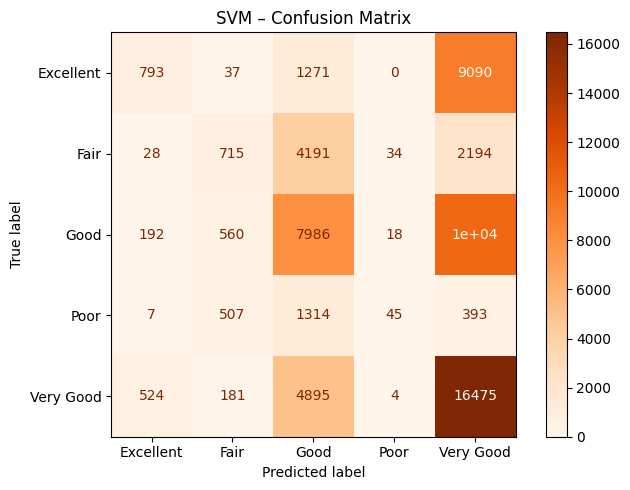

In [12]:
# Sample for speed (SVM is O(n²) in memory)
SAMPLE_SIZE = 30000
idx = np.random.choice(len(X_train_sc), size=SAMPLE_SIZE, replace=False)
X_train_svm = X_train_sc[idx]
y_train_svm = y_train.iloc[idx]

# ── Train ──────────────────────────────────────────────────────────────────────
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_svm, y_train_svm)

# ── Predict ────────────────────────────────────────────────────────────────────
svm_pred = svm_model.predict(X_test_sc)

# ── Evaluate ───────────────────────────────────────────────────────────────────
svm_acc = accuracy_score(y_test, svm_pred)
print(f'SVM Accuracy: {svm_acc:.4f} ({svm_acc*100:.2f}%)')
print('\nClassification Report:')
print(classification_report(y_test, svm_pred, target_names=le_dict[TARGET].classes_))

# ── Confusion Matrix ───────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test, svm_pred,
    display_labels=le_dict[TARGET].classes_,
    cmap='Oranges', ax=ax
)
ax.set_title('SVM – Confusion Matrix')
plt.tight_layout()
plt.show()

## Step 9 – Accuracy Comparison Bar Chart

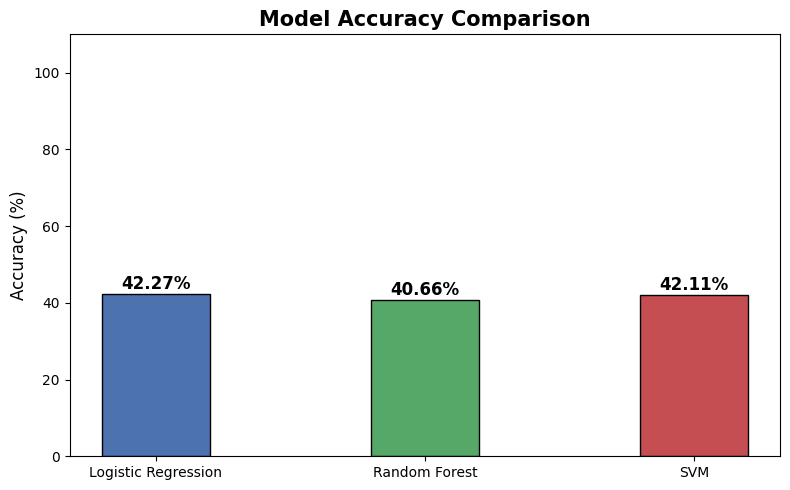

              Model  Accuracy (%)
Logistic Regression         42.27
      Random Forest         40.66
                SVM         42.11

🏆 Best Model: Logistic Regression


In [13]:
models      = ['Logistic Regression', 'Random Forest', 'SVM']
accuracies  = [lr_acc, rf_acc, svm_acc]
colors      = ['#4C72B0', '#55A868', '#C44E52']

plt.figure(figsize=(8, 5))
bars = plt.bar(models, [a * 100 for a in accuracies], color=colors, width=0.4, edgecolor='black')

# Add value labels on top of each bar
for bar, acc in zip(bars, accuracies):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.3,
        f'{acc*100:.2f}%',
        ha='center', va='bottom', fontsize=12, fontweight='bold'
    )

plt.ylim(0, 110)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Model Accuracy Comparison', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary table
results_df = pd.DataFrame({'Model': models, 'Accuracy (%)': [round(a*100, 2) for a in accuracies]})
print(results_df.to_string(index=False))
best = results_df.loc[results_df['Accuracy (%)'].idxmax(), 'Model']
print(f'\n🏆 Best Model: {best}')

## Step 10 – Hyperparameter Tuning with Randomized Grid Search

We tune the **best performing model** (Random Forest) to squeeze out better accuracy.  
`RandomizedSearchCV` tries random combinations of parameters — faster than exhaustive grid search.

In [15]:
# ── Define parameter grid ──────────────────────────────────────────────────────
param_dist = {
    'n_estimators'     : [50, 100, 200, 300],
    'max_depth'        : [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'max_features'     : ['sqrt', 'log2']
}

# ── Randomized Search ──────────────────────────────────────────────────────────
rf_tuned = RandomizedSearchCV(
    estimator  = RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions = param_dist,
    n_iter     = 10,          # Try 10 random combinations
    cv         = 3,           # 3-fold cross-validation
    scoring    = 'accuracy',
    random_state = 42,
    verbose    = 2,
    n_jobs     = -1
)

rf_tuned.fit(X_train, y_train)

print('\n✅ Best Parameters found:')
print(rf_tuned.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ Best Parameters found:
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}


In [16]:
# Evaluate tuned model
tuned_pred = rf_tuned.best_estimator_.predict(X_test)
tuned_acc  = accuracy_score(y_test, tuned_pred)

print(f'Tuned Random Forest Accuracy : {tuned_acc*100:.2f}%')
print(f'Original Random Forest Accuracy: {rf_acc*100:.2f}%')
print(f'Improvement: {(tuned_acc - rf_acc)*100:+.2f}%')

print('\nClassification Report (Tuned RF):')
print(classification_report(y_test, tuned_pred, target_names=le_dict[TARGET].classes_))

Tuned Random Forest Accuracy : 42.79%
Original Random Forest Accuracy: 40.66%
Improvement: +2.13%

Classification Report (Tuned RF):
              precision    recall  f1-score   support

   Excellent       0.53      0.09      0.15     11191
        Fair       0.38      0.11      0.17      7162
        Good       0.41      0.47      0.44     19073
        Poor       0.48      0.03      0.05      2266
   Very Good       0.44      0.71      0.54     22079

    accuracy                           0.43     61771
   macro avg       0.45      0.28      0.27     61771
weighted avg       0.44      0.43      0.38     61771



## Step 11 – Feature Importance (Random Forest)

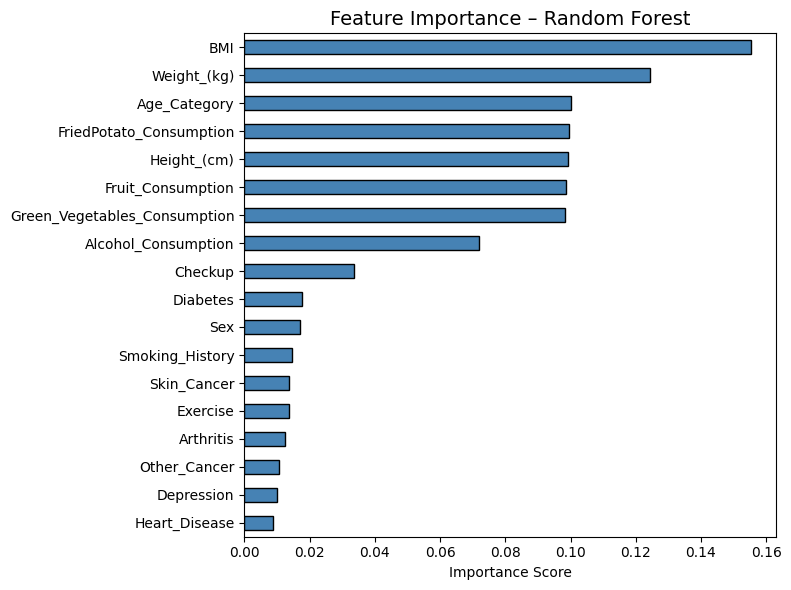

In [17]:
importances = pd.Series(
    rf_model.feature_importances_,
    index=X.columns
).sort_values(ascending=True)

plt.figure(figsize=(8, 6))
importances.plot(kind='barh', color='steelblue', edgecolor='black')
plt.title('Feature Importance – Random Forest', fontsize=14)
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

## Step 12 AI System: Single Input Prediction

This simulates how a real AI health prediction system works.

In [18]:
# ──  sample from the original (un-encoded) dataset ────────────────────
sample_index = 5
sample_raw   = df.iloc[sample_index].to_dict()
actual_label = sample_raw[TARGET]

print('=== INPUT: Patient Details ===')
for key, val in sample_raw.items():
    print(f'  {key:<35}: {val}')

# ── Encode the sample using stored encoders ───────────────────────────────────
sample_encoded = {}
for col in df.columns:
    if col == TARGET:
        continue
    val = sample_raw[col]
    if col in le_dict:
        sample_encoded[col] = le_dict[col].transform([val])[0]
    else:
        sample_encoded[col] = val

# ── Convert to DataFrame for prediction ───────────────────────────────────────
input_df = pd.DataFrame([sample_encoded])

# ── Predict using the Best Model (Tuned Random Forest) ────────────────────────
prediction_encoded = rf_tuned.best_estimator_.predict(input_df)[0]
prediction_label   = le_dict[TARGET].inverse_transform([prediction_encoded])[0]

# ── Get prediction probabilities ──────────────────────────────────────────────
proba = rf_tuned.best_estimator_.predict_proba(input_df)[0]
classes = le_dict[TARGET].classes_

print('\n=== 🤖 AI PREDICTION RESULT ===')
print(f'  Predicted General Health : {prediction_label}')
print(f'  Actual   General Health  : {actual_label}')
print(f'  Match                    : {"✅ CORRECT" if prediction_label == actual_label else "❌ INCORRECT"}')

print('\n=== Confidence Scores ===')
for cls, prob in sorted(zip(classes, proba), key=lambda x: -x[1]):
    bar = '█' * int(prob * 30)
    print(f'  {cls:<12}: {bar} {prob*100:.1f}%')

=== INPUT: Patient Details ===
  General_Health                     : Good
  Checkup                            : Within the past year
  Exercise                           : No
  Heart_Disease                      : No
  Skin_Cancer                        : No
  Other_Cancer                       : No
  Depression                         : Yes
  Diabetes                           : No
  Arthritis                          : Yes
  Sex                                : Male
  Age_Category                       : 60-64
  Height_(cm)                        : 183
  Weight_(kg)                        : 154.22
  BMI                                : 46.11
  Smoking_History                    : No
  Alcohol_Consumption                : 0
  Fruit_Consumption                  : 12
  Green_Vegetables_Consumption       : 12
  FriedPotato_Consumption            : 12

=== 🤖 AI PREDICTION RESULT ===
  Predicted General Health : Good
  Actual   General Health  : Good
  Match                    : ✅ CORREC

## Step 13 Custom Input Prediction

In [19]:
# Fill patient details manually ─────────────────────────────────────────
# Valid values shown for categorical columns

custom_input = {
    'Checkup'                      : 'Within the past year',   # 'Within the past year', 'Within the past 2 years', '5 or more years ago', 'Never'
    'Exercise'                     : 'Yes',                    # 'Yes' or 'No'
    'Heart_Disease'                : 'No',                     # 'Yes' or 'No'
    'Skin_Cancer'                  : 'No',                     # 'Yes' or 'No'
    'Other_Cancer'                 : 'No',                     # 'Yes' or 'No'
    'Depression'                   : 'No',                     # 'Yes' or 'No'
    'Diabetes'                     : 'No',                     # 'Yes' or 'No'
    'Arthritis'                    : 'No',                     # 'Yes' or 'No'
    'Sex'                          : 'Female',                 # 'Male' or 'Female'
    'Age_Category'                 : '25-29',                  # e.g. '18-24', '25-29', ..., '80+'
    'Height_(cm)'                  : 165,
    'Weight_(kg)'                  : 60,
    'BMI'                          : 22.0,
    'Smoking_History'              : 'No',                     # 'Yes' or 'No'
    'Alcohol_Consumption'          : 0,
    'Fruit_Consumption'            : 20,
    'Green_Vegetables_Consumption' : 15,
    'FriedPotato_Consumption'      : 5
}

# ── Encode ────────────────────────────────────────────────────────────────────
custom_encoded = {}
for col, val in custom_input.items():
    if col in le_dict:
        custom_encoded[col] = le_dict[col].transform([val])[0]
    else:
        custom_encoded[col] = val

custom_df = pd.DataFrame([custom_encoded])

# ── Predict ───────────────────────────────────────────────────────────────────
custom_pred_enc   = rf_tuned.best_estimator_.predict(custom_df)[0]
custom_pred_label = le_dict[TARGET].inverse_transform([custom_pred_enc])[0]
custom_proba      = rf_tuned.best_estimator_.predict_proba(custom_df)[0]

print('=== 🤖 AI Health Prediction System ===')
print(f'\nPredicted General Health Status: 👉 {custom_pred_label.upper()}')

print('\nConfidence Breakdown:')
for cls, prob in sorted(zip(le_dict[TARGET].classes_, custom_proba), key=lambda x: -x[1]):
    bar = '█' * int(prob * 30)
    print(f'  {cls:<12}: {bar} {prob*100:.1f}%')

=== 🤖 AI Health Prediction System ===

Predicted General Health Status: 👉 VERY GOOD

Confidence Breakdown:
  Very Good   : ████████████ 41.7%
  Excellent   : ██████████ 35.9%
  Good        : █████ 18.9%
  Fair        :  3.0%
  Poor        :  0.4%


In [ ]:
Random Forest achieved the highest accuracy and performed best for predicting General Health. Hyperparameter tuning further improved performance. Therefore, Random Forest is selected as the final deployment model.